Monter Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Vérifier que le zip est bien là

In [ ]:
!ls -lh /content/drive/MyDrive/scream_dataset

total 333M
drwx------ 2 root root 4.0K Jan 31 08:15 data
drwx------ 2 root root 4.0K Jan 31 08:23 final_dataset
-rw------- 1 root root 333M Jan 30 11:36 scream_dataset.zip


Dézipper la dataset

In [ ]:
!rm -rf /content/drive/MyDrive/scream_dataset/data
!mkdir -p /content/drive/MyDrive/scream_dataset/data
!unzip -q "/content/drive/MyDrive/scream_dataset/scream_dataset.zip" -d "/content/drive/MyDrive/scream_dataset/data"

Vérifier la structure: Check dossiers + wav

In [ ]:
!find /content/drive/MyDrive/scream_dataset/data -maxdepth 4 -type d
!find /content/drive/MyDrive/scream_dataset/data -name "*.wav" | head -n 10
!find /content/drive/MyDrive/scream_dataset/data -name "*.wav" | wc -l

/content/drive/MyDrive/scream_dataset/data
/content/drive/MyDrive/scream_dataset/data/scream_dataset
/content/drive/MyDrive/scream_dataset/data/scream_dataset/non_scream
/content/drive/MyDrive/scream_dataset/data/scream_dataset/scream
/content/drive/MyDrive/scream_dataset/data/scream_dataset/non_scream/1.wav
/content/drive/MyDrive/scream_dataset/data/scream_dataset/non_scream/10.wav
/content/drive/MyDrive/scream_dataset/data/scream_dataset/non_scream/100.wav
/content/drive/MyDrive/scream_dataset/data/scream_dataset/non_scream/1000.wav
/content/drive/MyDrive/scream_dataset/data/scream_dataset/non_scream/1001.wav
/content/drive/MyDrive/scream_dataset/data/scream_dataset/non_scream/1002.wav
/content/drive/MyDrive/scream_dataset/data/scream_dataset/non_scream/1003.wav
/content/drive/MyDrive/scream_dataset/data/scream_dataset/non_scream/1004.wav
/content/drive/MyDrive/scream_dataset/data/scream_dataset/non_scream/1005.wav
/content/drive/MyDrive/scream_dataset/data/scream_dataset/non_scream/

Installer les dépendances

In [ ]:
!pip install -q tensorflow_hub librosa scikit-learn seaborn

TRAIN COMPLET (YAMNet binaire)

In [ ]:
import os, glob, json
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import librosa
from sklearn.model_selection import train_test_split

# =========================
# CONFIG
# =========================
DATA_ROOT = "/content/drive/MyDrive/scream_dataset/data/scream_dataset"
OUT_DIR   = "/content/drive/MyDrive/scream_dataset"

SR = 16000
DURATION = 3.0
MAX_SAMPLES = int(SR * DURATION)

CLASSES = ["non_scream", "scream"]

# =========================
# LOAD FILES
# =========================
files, labels = [], []
for i, c in enumerate(CLASSES):
    class_dir = os.path.join(DATA_ROOT, c)
    wavs = glob.glob(os.path.join(class_dir, "*.wav"))
    files += wavs
    labels += [i] * len(wavs)

files = np.array(files)
labels = np.array(labels, dtype=np.int32)

print("Total:", len(files))
print("non_scream:", int((labels==0).sum()), "| scream:", int((labels==1).sum()))

X_train, X_val, y_train, y_val = train_test_split(
    files, labels, test_size=0.2, stratify=labels, random_state=42
)

# =========================
# AUDIO LOADER (librosa)
# =========================
def load_wav_librosa(path):
    path = path.numpy().decode("utf-8")
    wav, _ = librosa.load(path, sr=SR, mono=True)
    if len(wav) < MAX_SAMPLES:
        wav = np.pad(wav, (0, MAX_SAMPLES - len(wav)))
    else:
        wav = wav[:MAX_SAMPLES]
    return wav.astype(np.float32)

def tf_load_example(path, label):
    wav = tf.py_function(load_wav_librosa, inp=[path], Tout=tf.float32)
    wav.set_shape([MAX_SAMPLES])
    return wav, label

AUTOTUNE = tf.data.AUTOTUNE
def make_ds(X, y, training=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(min(len(X), 2000), reshuffle_each_iteration=True)
    ds = ds.map(tf_load_example, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(16).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(X_train, y_train, training=True)
val_ds   = make_ds(X_val, y_val, training=False)

# =========================
# YAMNET WRAPPER LAYER
# =========================
yamnet = hub.KerasLayer("https://tfhub.dev/google/yamnet/1", trainable=False)

class YamnetEmbed(tf.keras.layers.Layer):
    def __init__(self, yamnet_layer, **kwargs):
        super().__init__(**kwargs)
        self.yamnet_layer = yamnet_layer

    def call(self, wave_batch):
        # wave_batch: (batch, samples)
        def one(w):
            scores, embeddings, _ = self.yamnet_layer(w)
            return tf.reduce_mean(embeddings, axis=0)
        return tf.map_fn(one, wave_batch, fn_output_signature=tf.float32)

embed_layer = YamnetEmbed(yamnet)

# =========================
# MODEL
# =========================
inp = tf.keras.Input(shape=(MAX_SAMPLES,), dtype=tf.float32, name="waveform")
x = embed_layer(inp)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
out = tf.keras.layers.Dense(2, activation="softmax")(x)

model = tf.keras.Model(inp, out)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# =========================
# CHECKPOINT (save weights only)
# =========================
best_weights = os.path.join(OUT_DIR, "best_weights.weights.h5")
cb = tf.keras.callbacks.ModelCheckpoint(
    best_weights,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)

# =========================
# TRAIN
# =========================
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[cb])

# Load best weights
model.load_weights(best_weights)

# Save labels
with open(os.path.join(OUT_DIR, "labels.json"), "w") as f:
    json.dump(CLASSES, f, indent=2)

print("✅ Best weights saved:", best_weights)
print("✅ Labels saved:", os.path.join(OUT_DIR, "labels.json"))


Total: 3128
non_scream: 1545 | scream: 1583
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 170s 933ms/step - accuracy: 0.7750 - loss: 0.6201 - val_accuracy: 0.8435 - val_loss: 0.3149
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 141s 895ms/step - accuracy: 0.9205 - loss: 0.2102 - val_accuracy: 0.9217 - val_loss: 0.1772
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 132s 843ms/step - accuracy: 0.9377 - loss: 0.1603 - val_accuracy: 0.9393 - val_loss: 0.1594
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 135s 862ms/step - accuracy: 0.9301 - loss: 0.1851 - val_accuracy: 0.9281 - val_loss: 0.1947
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.9539 - loss: 0.1284 - val_accuracy: 0.9553 - val_loss: 0.1462
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 152s 966ms/step - accuracy: 0.9550 - loss: 0.1296 - val_accuracy: 0.9441 - val_loss: 0.1448
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.9527 - loss: 0.1373 - val_accuracy: 0.9457 - val_loss: 0.1423
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━

TEST + Confusion Matrix + test_results.json

✅ Validation Accuracy: 95.52715654952077

📋 Classification report:

              precision    recall  f1-score   support

  non_scream      0.958     0.951     0.955       309
      scream      0.953     0.959     0.956       317

    accuracy                          0.955       626
   macro avg      0.955     0.955     0.955       626
weighted avg      0.955     0.955     0.955       626



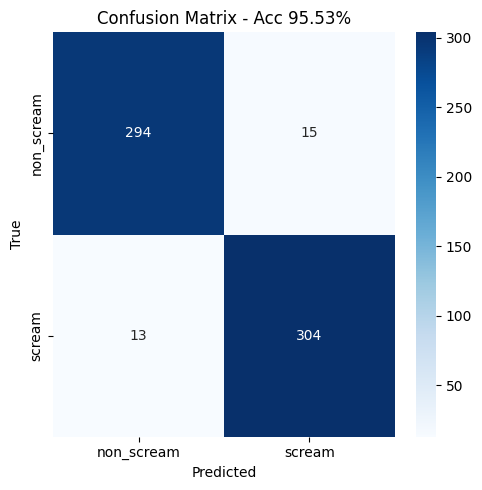

✅ Saved confusion matrix: /content/drive/MyDrive/scream_dataset/test_confusion_matrix.png
✅ Saved results: /content/drive/MyDrive/scream_dataset/test_results.json


In [ ]:
import os, json, numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

OUT_DIR = "/content/drive/MyDrive/scream_dataset"
CLASSES = ["non_scream", "scream"]

best_weights = os.path.join(OUT_DIR, "best_weights.weights.h5")
model.load_weights(best_weights)  # s’assurer qu’on a les meilleurs

preds, trues = [], []
for x, y in val_ds:
    p = model(x)
    preds.extend(tf.argmax(p, axis=1).numpy())
    trues.extend(y.numpy())

acc = 100 * accuracy_score(trues, preds)
print("✅ Validation Accuracy:", acc)

print("\n📋 Classification report:\n")
print(classification_report(trues, preds, target_names=CLASSES, digits=3))

cm = confusion_matrix(trues, preds)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=CLASSES, yticklabels=CLASSES, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - Acc {acc:.2f}%")
plt.tight_layout()

cm_path = os.path.join(OUT_DIR, "test_confusion_matrix.png")
plt.savefig(cm_path, dpi=300)
plt.show()

results = {
    "val_accuracy": float(acc),
    "num_val_samples": int(len(trues)),
    "classes": CLASSES
}

json_path = os.path.join(OUT_DIR, "test_results.json")
with open(json_path, "w") as f:
    json.dump(results, f, indent=2)

print("✅ Saved confusion matrix:", cm_path)
print("✅ Saved results:", json_path)


Prédire un seul fichier WAV

In [ ]:
import os, json
import numpy as np
import librosa
import tensorflow as tf

OUT_DIR = "/content/drive/MyDrive/scream_dataset"
labels = json.load(open(os.path.join(OUT_DIR, "labels.json")))

SR = 16000
DURATION = 3.0
MAX_SAMPLES = int(SR * DURATION)

def preprocess_one(path):
    wav, _ = librosa.load(path, sr=SR, mono=True)
    if len(wav) < MAX_SAMPLES:
        wav = np.pad(wav, (0, MAX_SAMPLES - len(wav)))
    else:
        wav = wav[:MAX_SAMPLES]
    return wav.astype(np.float32)

def predict_one(wav_path):
    wav = preprocess_one(wav_path)
    proba = model(np.expand_dims(wav, axis=0)).numpy()[0]
    idx = int(proba.argmax())
    return labels[idx], float(proba[idx])

print(predict_one("/content/drive/MyDrive/scream_dataset/data/scream_dataset/scream/1.wav"))
print(predict_one("/content/drive/MyDrive/scream_dataset/data/scream_dataset/non_scream/1.wav"))


('scream', 0.9896565675735474)
('non_scream', 0.8606041073799133)
